#1 영화마다 평론에 대한 문장을 토큰화
#2 토큰화된 문장을 기존 임베딩된 값으로 대체
#3 단어에 대한 평균값을 그 영화의 평론에 대한 대표 임베딩값으로 정의
#4 메트릭스 형태의 영화마다 코사인유사도 값을 구함
#5 선택된 영화와 유사한 상위 5개의 영화 추천

In [28]:
import os
import re

os.chdir(r"c:\projects\PY_MLE")

import pandas as pd
import numpy as np
import re
import urllib.request
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
df = pd.read_csv('data.csv')
print("data size:{}".format(len(df)))

data size:2382


In [30]:
df[:5]

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [31]:
# 몇가지 특수기호, 숫자, 영어만. 저 아래 영문 단위로 하기 때문에 이 함수는 필요 없는 듯 한데
def _removeNonAscii(text):
    return "".join(i for i in text if ord(i) < 128)

def make_lower_case(text):
    return text.lower()

# 음절단위로 분리
def remove_stop_word(text):
    text = text.split()
    stops = set(stopwords.words('english'))
    text = [word for word in text if not word in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)


# 영문단위로 분리한다.
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text


In [32]:
df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df['cleaned'].apply(make_lower_case)
df['cleaned'] = df['cleaned'].apply(remove_stop_word)
df['cleaned'] = df['cleaned'].apply(remove_html)
df['cleaned'] = df['cleaned'].apply(remove_punctuation)

In [33]:
df[:5]

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title,cleaned
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...,know power shifting west east north south pres...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t...",following success accidental billionaires mone...
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...,tap power social software networks build busin...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing,william j bernstein american financial theoris...
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony,amazing book joined steve jobs many akio morit...


In [34]:
# nan찾기
# df['cleaned'] = df['cleaned'].replace('', np.nan)
# nan_a_rows = df[df['cleaned'].isna()]
# print(nan_a_rows)
# df[2017:2018]
# df['cleaned'].isnull().value_counts()

# NaN 제거 또는 아닌 것만 불러오기
# df = df['cleaned'].dropna(axis=0).to_frame()
# df = df[df['cleaned'].notna()]

# 이렇게 하면 안된다.
# df['cleaned'] = df['cleaned'].dropna(axis=0)
# print("df size:{}".format(len(df)))

In [35]:
df['cleaned'] = df['cleaned'].replace('', np.nan)
print("df size:{}".format(len(df)))
# df = df['cleaned'].dropna(axis=0).to_frame()
df = df[df['cleaned'].notna()]
print("df size:{}".format(len(df)))



df size:2382
df size:2381


In [36]:
corpus = []
for word in df['cleaned']:
    corpus.append(word.split())

In [37]:
corpus[:2]

[['know',
  'power',
  'shifting',
  'west',
  'east',
  'north',
  'south',
  'presidential',
  'palaces',
  'public',
  'squares',
  'formidable',
  'corporate',
  'behemoths',
  'nimble',
  'startups',
  'and',
  'slowly',
  'surely',
  'men',
  'women',
  'power',
  'merely',
  'shifting',
  'dispersing',
  'also',
  'decaying',
  'power',
  'today',
  'constrained',
  'risk',
  'losing',
  'ever',
  'before',
  'end',
  'power',
  'award',
  'winning',
  'columnist',
  'former',
  'foreign',
  'policy',
  'editor',
  'moiss',
  'nam',
  'illuminates',
  'struggle',
  'once',
  'dominant',
  'megaplayers',
  'new',
  'micropowers',
  'challenging',
  'every',
  'field',
  'human',
  'endeavor',
  'drawing',
  'provocative',
  'original',
  'research',
  'nam',
  'shows',
  'antiestablishment',
  'drive',
  'micropowers',
  'topple',
  'tyrants',
  'dislodge',
  'monopolies',
  'open',
  'remarkable',
  'new',
  'opportunities',
  'also',
  'lead',
  'chaos',
  'paralysis',
  'nam',

In [38]:
# 사전훈련된 워드 임베딩 사용하기. 소스에는 url불러오는데 이미 불러온 데이터 사용
# word2vec_model = Word2Vec( vector_size=300, window=5, min_count=2, workers=1)
# word2vec_model.build_vocab(corpus) # 단어집합을 만들어 줌 fit_on_texts와 동일한다
# print(len(word2vec_model.wv.index_to_key))

# 위에 2문장을 이렇게 한문장으로 가능한듯
word2vec_model = Word2Vec(corpus, vector_size=300, window=5, min_count=2, workers=1)
# print(len(word2vec_model.wv.index_to_key))
# print(word2vec_model.corpus_count)
# print(word2vec_model.wv.key_to_index)

# 인터넷의 최신 파일을 반영. pdf 소스는 옛날 소스임
word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv), dtype=np.float32) # 추가 학습할지를 결정 행마다 1.0은 추가학습
word2vec_model.wv.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
word2vec_model.train(corpus, total_examples=word2vec_model.corpus_count,epochs=15)

(3687092, 3972510)

In [39]:
print(word2vec_model.wv.index_to_key)
print(word2vec_model.wv.key_to_index)

['s', 'one', 'new', 'world', 'book', 'business', 'life', 'people', 'time', 'work', 'story', 'first', 'way', 'the', 'make', 'years', 'like', 'us', 'love', 'best', 'novel', 'author', 'two', 'it', 'success', 'every', 'and', 'even', 'get', 'company', 'lives', 'family', 'companies', 'in', 'also', 'man', 'power', 'great', 'change', 'day', 'year', 'help', 'find', 'many', 'become', 'must', 'young', 'well', 'times', 'shows', 'old', 'learn', 'stories', 'ever', 'readers', 'successful', 'human', 'york', 'want', 'never', 'powerful', 'american', 'long', 'a', 'real', 'marketing', 'know', 'better', 'good', 'need', 'ideas', 'others', 'management', 'read', 'take', 'guide', 'much', 'history', 'three', 'back', 'think', 'today', 'to', 'financial', 'use', 'edition', 'would', 'home', 'small', 'money', 'anyone', 'future', 'books', 'could', 'war', 'things', 'high', 'around', 'offers', 'leadership', 'create', 'everything', 'right', 'made', 'little', 'set', 'job', 'yet', 'customers', 'practical', 'now', 'school'

In [40]:
# 각 문장에 있는 단어들을 평균하여 그 문장의 벡터값으로 결정
# 이건 규칙이 아니라 그렇게도 되지 않을까 하는 하나의 방법이다.
def get_document_vectors(document_list):
    document_embedding_list = []

    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.index_to_key:
                count += 1
                if doc2vec is None:
                    doc2vec = word2vec_model.wv[word]
                else:
                    doc2vec = doc2vec + word2vec_model.wv[word]

        if doc2vec is not None:
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    return document_embedding_list

In [41]:
document_embedding_list = get_document_vectors(df['cleaned'])
print(len(document_embedding_list))

2381


In [42]:
# 코사인 유사도 구하기
cosine_sim = cosine_similarity(document_embedding_list, document_embedding_list)
cosine_sim

array([[1.        , 0.81066096, 0.76943856, ..., 0.77344066, 0.56509   ,
        0.68298304],
       [0.81066096, 1.0000002 , 0.6726313 , ..., 0.69624376, 0.72957397,
        0.64965546],
       [0.76943856, 0.6726313 , 0.99999994, ..., 0.5397842 , 0.422158  ,
        0.5111159 ],
       ...,
       [0.7734407 , 0.6962439 , 0.53978413, ..., 1.0000001 , 0.4241702 ,
        0.81688213],
       [0.56509   , 0.7295741 , 0.4221581 , ..., 0.4241702 , 1.0000001 ,
        0.43463337],
       [0.68298304, 0.64965546, 0.5111159 , ..., 0.816882  , 0.43463343,
        0.99999994]], dtype=float32)

In [55]:
# 입력한 벡터값과 가장 유사한 상위 5개를 구함
def recommendations(title):
    books = df[['title','image_link']]
    print(len(books))

    # # 아에 타이틀이 중복된 것 삭제해버는게 낫지 않을까 싶네...전처리 과정에서
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
    idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6] # 0은 자신이기 때문에 1부터 한다.

    # 임베딩으로 부터 인덱스를 구한다.
    book_indices = [i[0] for i in sim_scores]

    recommand = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    for index, row in recommand.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1,5, index+1)
        plt.imshow(img)
        plt.title(row['title'])


2381


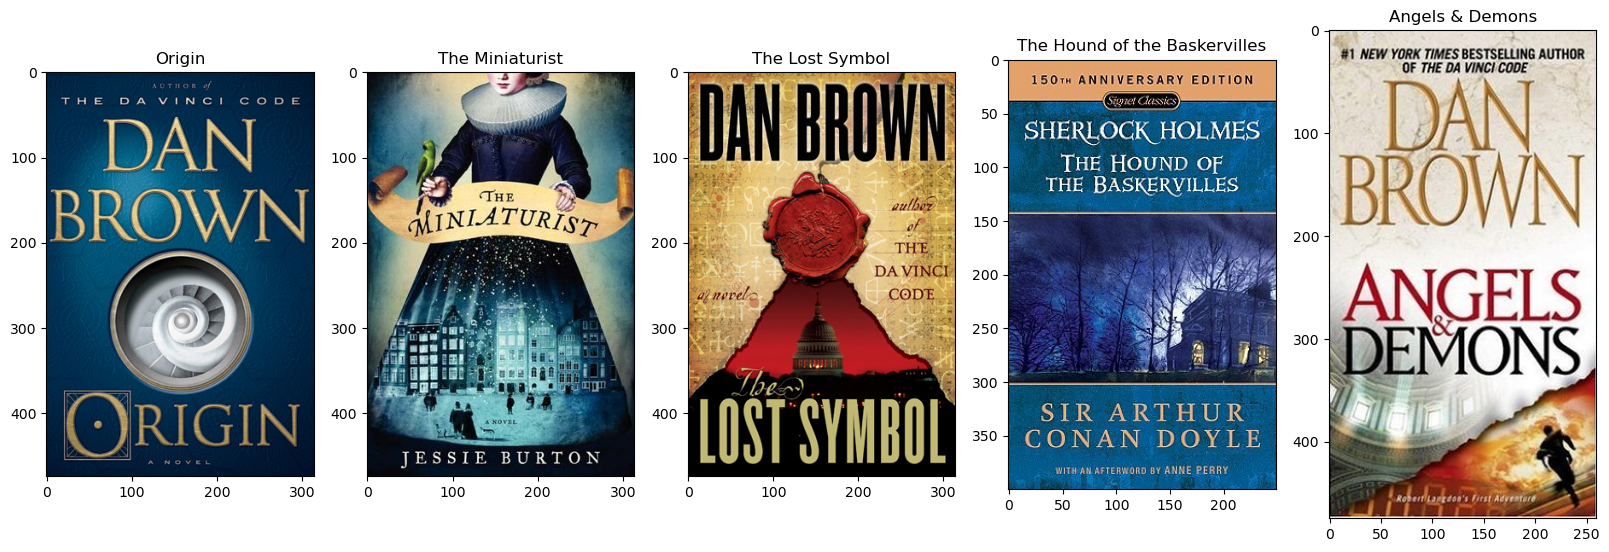

In [56]:
# 테스트
recommendations("The Da Vinci Code")